In [47]:
import pandas as pd
import numpy as np
import joblib

from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import randint, uniform

In [48]:
df = pd.read_csv(r"..\data\training_dataset_num_votes_log_1000.csv", sep=";")
df = df.drop(columns=['Unnamed: 0', 'averageRating', 'numVotes', '_orig_order'])
y = df["movie_score"].values
X = df.drop(columns=["movie_score"])  # + your drop columns

In [49]:
y.min()

np.float64(6.90975328164481)

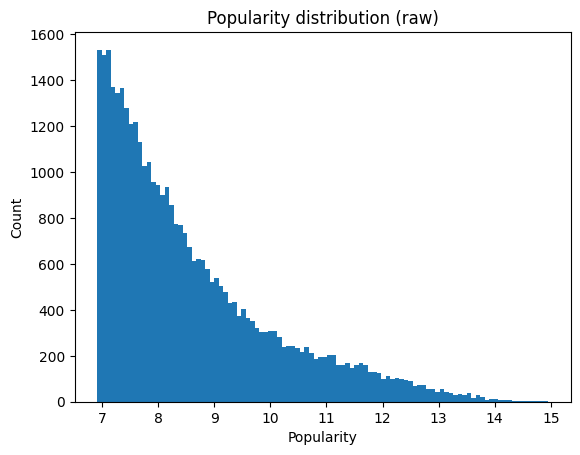

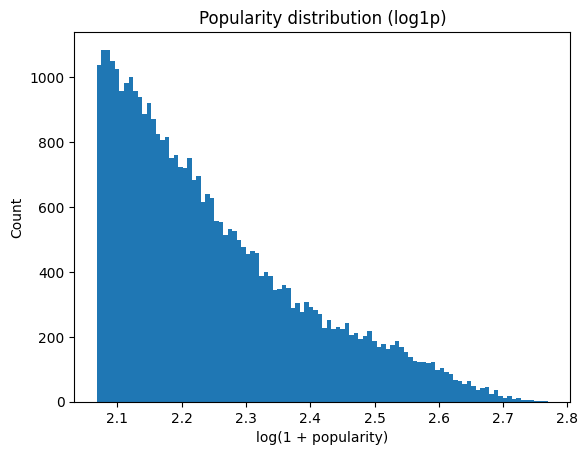

In [50]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure()
plt.hist(y, bins=100)
plt.title("Popularity distribution (raw)")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.hist(np.log1p(y), bins=100)
plt.title("Popularity distribution (log1p)")
plt.xlabel("log(1 + popularity)")
plt.ylabel("Count")
plt.show()


In [ ]:

base = XGBRegressor(
    objective="reg:tweedie",
    random_state=42,
    n_jobs=-1,
    tree_method="hist",   
    device="cuda"         
)

param_dist = {
    "n_estimators": randint(500, 5000),
    "learning_rate": uniform(0.01, 0.15),
    "max_depth": randint(2, 12),
    "min_child_weight": uniform(0.5, 6),
    "subsample": uniform(0.7, 0.3),
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0.0, 0.3),
    "reg_alpha": uniform(0.0, 0.5),
    "reg_lambda": uniform(0.0, 2.0),
    "max_delta_step": randint(0, 3),
    "tweedie_variance_power": uniform(1.1, 0.9),  # range: 1.1 → 2.0
}



In [52]:
cv = TimeSeriesSplit(n_splits=5)

search = RandomizedSearchCV(
    estimator=base,
    param_distributions=param_dist,
    n_iter=50,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    verbose=1,
    n_jobs=1,
    random_state=42,
)

search.fit(X, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_distributions,"{'colsample_bytree': <scipy.stats....0020498B6F460>, 'gamma': <scipy.stats....0020498B6FA80>, 'learning_rate': <scipy.stats....002049918C830>, 'max_delta_step': <scipy.stats....0020498B6FF50>, ...}"
,n_iter,50
,scoring,'neg_root_mean_squared_error'
,n_jobs,1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [46]:
best_model = search.best_estimator_

# Refit best model on ALL data (still no validation set)
best_model.fit(X, y, verbose=False)

joblib.dump(best_model, "xgb_reg_movie_score_cv_tweedie_rmae_over_1000.joblib")

cv_results = pd.DataFrame(search.cv_results_)
cv_results.to_csv("xgb_cv_results_movie_score_tweedie_rmae_over_1000.csv", index=False)

print("Best params:", search.best_params_)
print("Best CV RMSE:", -search.best_score_)


Best params: {'colsample_bytree': np.float64(0.8371795484841185), 'gamma': np.float64(0.2526069225035944), 'learning_rate': np.float64(0.03915700509923095), 'max_delta_step': 1, 'max_depth': 4, 'min_child_weight': np.float64(4.324579408989239), 'n_estimators': 4864, 'reg_alpha': np.float64(0.4847684335570795), 'reg_lambda': np.float64(1.4291902083599042), 'subsample': np.float64(0.7123202550303627), 'tweedie_variance_power': np.float64(1.4589388113003152)}
Best CV RMSE: 1.068325762530376
